<a href="https://colab.research.google.com/github/ayush-96/msc-data-science/blob/master/text_as_data/TaD_Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !pip install -U spacy
# !python -m spacy download en
# !pip install accelerate==0.27.0
# !pip install datasets
# !pip install transformers datasets evaluate torch scikit-learn

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import spacy
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import AutoTokenizer, pipeline, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset

from collections import Counter

In [6]:
file_location = "./dataset.json"
prompt1 = "./llm_prompt_template_1.json"
prompt2 = "./llm_prompt_template_2.json"
prompt3 = "./llm_prompt_template_3.json"

f = open(file_location)
dataset = json.load(f)

In [7]:
# Creating the required dataframes - train, validation, test
trainDF = pd.DataFrame(dataset['train'])
valDF = pd.DataFrame(dataset['val'])
testDF = pd.DataFrame(dataset['test'])
display(trainDF)

,id,labl,description,content,text,key,label
0,08838524-6d11-729c-39d8-fa4d712b7476,1,Exhaust steam pipe protector piece fitted belo...,NaN,NaN,NaN,NaN
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,"oyal Botanic Gardens, Kew",NaN,This journal seems to have been kept parallel ...,NaN,NaN,NaN
2,7ab43067-856c-5cee-8574-ac59a24de44b,"Royal Botanic Gardens, Kew",NaN,NaN,None,NaN,NaN
3,b78f8473-e487-b3cb-be65-4f854d97228b,"Royal Botanic Gardens, Kew",'Remainder Correspondence of the Bibliographic...,NaN,NaN,NaN,NaN
4,ea15bfc9-9499-e9e2-b3e4-654714a795a5,NaN,The particulars of an inquest upon the murder ...,NaN,NaN,hakespeare Birthplace Trust,NaN
...,...,...,...,...,...,...,...
150,246aeb01-6686-57ab-9f4e-3a15f01446e5,Royal College of Physicians of London,535970,NaN,NaN,NaN,NaN
151,1a81f93b-6256-ff41-2117-a23a1c4d7156,NaN,NaN,"Philip Stephens. James Bull, late a Clerk in t...",NaN,0,NaN
152,5911d963-3dae-5839-2443-960930f73aa3,NaN,"Deposition by Thomas Jewell, Shipwright. When ...",NaN,NaN,NaN,National Maritime Museum
153,cdba4d41-7d2b-e7ea-5b15-77c7b7c1b6e0,Shakespeare Birthplace Trust,NaN,NaN,The daughters of William Harbord esq. deceased...,NaN,NaN


In [8]:
# Consolidate 'label' column
for df in [trainDF]:  # val, test df have proper columns so only trainDF
    df['label'] = df[['label', 'labl', 'key']].bfill(axis='columns').iloc[:, 0]
    df['label'] = df['label'].astype(str).str.strip()
    df['content'] = df[['description', 'content', 'text']].bfill(axis=1).iloc[:, 0]
    df.drop(columns=['labl', 'key', 'description', 'text'], errors='ignore', inplace=True)
display(trainDF)

,id,content,label
0,08838524-6d11-729c-39d8-fa4d712b7476,Exhaust steam pipe protector piece fitted belo...,1
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,This journal seems to have been kept parallel ...,"oyal Botanic Gardens, Kew"
2,7ab43067-856c-5cee-8574-ac59a24de44b,None,"Royal Botanic Gardens, Kew"
3,b78f8473-e487-b3cb-be65-4f854d97228b,'Remainder Correspondence of the Bibliographic...,"Royal Botanic Gardens, Kew"
4,ea15bfc9-9499-e9e2-b3e4-654714a795a5,The particulars of an inquest upon the murder ...,hakespeare Birthplace Trust
...,...,...,...
150,246aeb01-6686-57ab-9f4e-3a15f01446e5,535970,Royal College of Physicians of London
151,1a81f93b-6256-ff41-2117-a23a1c4d7156,"Philip Stephens. James Bull, late a Clerk in t...",0
152,5911d963-3dae-5839-2443-960930f73aa3,"Deposition by Thomas Jewell, Shipwright. When ...",National Maritime Museum
153,cdba4d41-7d2b-e7ea-5b15-77c7b7c1b6e0,The daughters of William Harbord esq. deceased...,Shakespeare Birthplace Trust


In [9]:
trainDF['label'].value_counts()
valDF['label'].value_counts()

,count
label,
National Railway Museum,13
"Royal Botanic Gardens, Kew",11
Royal College of Physicians of London,10
Shakespeare Birthplace Trust,8
National Maritime Museum,8


In [10]:
# label column mapping
label_mapping = {
    'National Maritime Museum': '0',
    'ational Maritime Museum': '0',
    'National Railway Museum': '1',
    'ational Railway Museum': '1',
    'Royal Botanic Gardens, Kew': '2',
    'oyal Botanic Gardens, Kew': '2',
    'Royal College of Physicians of London': '3',
    'oyal College of Physicians of London': '3',
    'Shakespeare Birthplace Trust': '4',
    'hakespeare Birthplace Trust': '4'
}
trainDF['label'] = trainDF['label'].map(lambda x: label_mapping.get(x, x))
trainDF['label'] = trainDF['label'].astype(int)

valDF['label'] = valDF['label'].map(lambda x: label_mapping.get(x, x))
valDF['label'] = valDF['label'].astype(int)

testDF['label'] = testDF['label'].map(lambda x: label_mapping.get(x, x))
testDF['label'] = testDF['label'].astype(int)

trainDF['content'] = trainDF['content'].astype(str)
valDF['content'] = valDF['content'].astype(str)
testDF['content'] = testDF['content'].astype(str)

testDF['label'].value_counts()

,count
label,
4,13
0,13
2,11
1,7
3,6


In [11]:
# Remove rows where 'content' is NaN
trainDF = trainDF.dropna(subset=['content'])
valDF = valDF.dropna(subset=['content'])
testDF = testDF.dropna(subset=['content'])

display(trainDF)  # 2 rows dropped 2, 147

,id,content,label
0,08838524-6d11-729c-39d8-fa4d712b7476,Exhaust steam pipe protector piece fitted belo...,1
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,This journal seems to have been kept parallel ...,2
2,7ab43067-856c-5cee-8574-ac59a24de44b,None,2
3,b78f8473-e487-b3cb-be65-4f854d97228b,'Remainder Correspondence of the Bibliographic...,2
4,ea15bfc9-9499-e9e2-b3e4-654714a795a5,The particulars of an inquest upon the murder ...,4
...,...,...,...
150,246aeb01-6686-57ab-9f4e-3a15f01446e5,535970,3
151,1a81f93b-6256-ff41-2117-a23a1c4d7156,"Philip Stephens. James Bull, late a Clerk in t...",0
152,5911d963-3dae-5839-2443-960930f73aa3,"Deposition by Thomas Jewell, Shipwright. When ...",0
153,cdba4d41-7d2b-e7ea-5b15-77c7b7c1b6e0,The daughters of William Harbord esq. deceased...,4


<H1>Exploration</H1>

In [12]:
# Load Spacy NLP model
nlp = spacy.load("en_core_web_sm")

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

In [13]:
# Q2 a: Report sample counts
train_count = len(trainDF)
val_count = len(valDF)
test_count = len(testDF)
print(f"Sample counts:\nTrain: {train_count}\nValidation: {val_count}\nTest: {test_count}")

Sample counts:
Train: 155
Validation: 50
Test: 50


In [14]:
# Q2 b: Report percentage splits
total_count = train_count + val_count + test_count
print(f"Percentage splits:\nTrain: {train_count / total_count * 100:.2f}%\n"
      f"Validation: {val_count / total_count * 100:.2f}%\n"
      f"Test: {test_count / total_count * 100:.2f}%")

Percentage splits:
Train: 60.78%
Validation: 19.61%
Test: 19.61%


In [15]:
# Q2 c: Report min and max length of texts (in characters)
for name, df in zip(["Train", "Validation", "Test"], [trainDF, valDF, testDF]):
    text_lengths = df['content'].str.len()
    print(f"{name} set: Min length = {text_lengths.min()} characters, Max length = {text_lengths.max()} characters")

Train set: Min length = 4 characters, Max length = 4263 characters
Validation set: Min length = 154 characters, Max length = 2794 characters
Test set: Min length = 167 characters, Max length = 3479 characters


In [16]:
# Q2 d: Report most frequent 5 tokens per class
label_classes = trainDF['label'].unique()
token_frequencies = {}

for label in label_classes:
    texts = trainDF[trainDF['label'] == label]['content'].dropna()
    all_tokens = []

    for text in texts:
        all_tokens.extend(text_pipeline_spacy(text))

    token_frequencies[label] = Counter(all_tokens).most_common(5)

# Display the top 5 tokens per class
for label, tokens in token_frequencies.items():
    print(f"Class {label} - Most Frequent Tokens: {tokens}")

Class 1 - Most Frequent Tokens: [('2000', 144), ('7200', 144), ('756', 143), ('gb', 142), ('collection', 31)]
Class 2 - Most Frequent Tokens: [('letter', 30), ('include', 15), ('paper', 14), ('list', 12), ('contain', 11)]
Class 4 - Most Frequent Tokens: [('mr.', 18), ('work', 16), ('bill', 15), ('account', 14), ('letter', 14)]
Class 0 - Most Frequent Tokens: [('john', 16), ('sir', 11), ('henry', 10), ('enclosure', 10), ('james', 9)]
Class 3 - Most Frequent Tokens: [('seal', 25), ('common', 21), ('mr.', 17), ('college', 17), ('fellow', 16)]


<H1>Prompting with a large language model</H1>

In [17]:
# reading prompts file
prompt1DF = pd.read_json(prompt1)
prompt2DF = pd.read_json(prompt2)
prompt3DF = pd.read_json(prompt3)

display(prompt3DF)
trainDF.info()

,id,prompt,next_token
0,08838524-6d11-729c-39d8-fa4d712b7476,Record: Exhaust steam pipe protector piece fit...,1
1,467eb98e-1866-708e-03cd-9ab9f8a7f4e5,Record: This journal seems to have been kept p...,2
2,b78f8473-e487-b3cb-be65-4f854d97228b,Record: 'Remainder Correspondence of the Bibli...,1
3,ea15bfc9-9499-e9e2-b3e4-654714a795a5,Record: The particulars of an inquest upon the...,0
4,03556d52-3c1e-f36e-97bd-1a09c87ef949,Record: London Brighton & South Coast Railway ...,1
...,...,...,...
145,0696ec91-691f-3e27-f5c2-5628ccd88956,Record: List of Commissioners with all their d...,I
146,1a81f93b-6256-ff41-2117-a23a1c4d7156,"Record: Philip Stephens. James Bull, late a Cl...",0
147,5911d963-3dae-5839-2443-960930f73aa3,"Record: Deposition by Thomas Jewell, Shipwrigh...",0
148,cdba4d41-7d2b-e7ea-5b15-77c7b7c1b6e0,Record: The daughters of William Harbord esq. ...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       155 non-null    object
 1   content  155 non-null    object
 2   label    155 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.8+ KB


In [18]:
# Load LLM Prompt Results
prompt_files = [prompt1, prompt2, prompt3]

def load_predictions(file_path):
    """Load LLM predictions and process them."""
    with open(file_path, "r", encoding="utf-8") as file:
        llm_preds = json.load(file)
    pred_df = pd.DataFrame(llm_preds)

    # Convert invalid responses to class 5
    pred_df['next_token'] = pred_df['next_token'].apply(lambda x: int(x) if x.isdigit() else 5)
    return pred_df

# Load predictions for each prompt
llm_results = [load_predictions(f) for f in prompt_files]

# Merge predictions with ground truth labels
for i, llm_df in enumerate(llm_results):
    merged_df = trainDF.merge(llm_df[['id', 'next_token']], on="id", how="inner")

    y_true = merged_df['label'].values
    y_pred = merged_df['next_token'].values

    # Compute evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # Print results for this prompt
    print(f"\nResults for LLM Prompt Template {i+1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1-score: {f1:.4f}")


Results for LLM Prompt Template 1:
Accuracy: 0.0000
Macro Precision: 0.0000
Macro Recall: 0.0000
Macro F1-score: 0.0000

Results for LLM Prompt Template 2:
Accuracy: 0.7600
Macro Precision: 0.7886
Macro Recall: 0.7549
Macro F1-score: 0.7434

Results for LLM Prompt Template 3:
Accuracy: 0.7067
Macro Precision: 0.6743
Macro Recall: 0.5828
Macro F1-score: 0.5846


<H1>Fine-tune a transformer</H1>

In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
pipe = pipeline('feature-extraction', model="bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=512)

# Convert DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(trainDF[['content', 'label']])
val_dataset = Dataset.from_pandas(valDF[['content', 'label']])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Device set to use cuda:0


In [20]:
valDF['label'].value_counts()

,count
label,
1,13
2,11
3,10
4,8
0,8


In [21]:
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Remove extra columns and set format
train_dataset = train_dataset.remove_columns(["content"])
val_dataset = val_dataset.remove_columns(["content"])

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Load BERT model for classification (num_labels = 5)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

# Define training arguments
training_args = TrainingArguments(
    output_dir="bert_finetuned_model",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define evaluation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)

    per_class_scores = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)

    print("\nPer-Class Evaluation Metrics:")
    for i in range(len(per_class_scores[0])):  # Loop correctly over available classes
        print(f"Class {i}: Precision={per_class_scores[0][i]:.4f}, Recall={per_class_scores[1][i]:.4f}, F1={per_class_scores[2][i]:.4f}")

    return {
        "accuracy": accuracy,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1
    }

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save the trained model
trainer.save_model("bert_finetuned_model")
tokenizer.save_pretrained("bert_finetuned_model")

# Evaluate the model
trainer.evaluate()

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-fb759e1eb986>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,1.367100,1.528094,0.220000,0.262338,0.234091,0.238596
2,1.051200,1.835529,0.240000,0.283333,0.225000,0.231304
3,0.553200,2.163941,0.220000,0.146667,0.200000,0.169231
4,0.217900,2.632059,0.240000,0.205556,0.225000,0.214834
5,0.094900,3.302513,0.220000,0.183333,0.200000,0.191304
6,0.049900,3.851766,0.220000,0.183333,0.200000,0.191304
7,0.049500,4.005417,0.220000,0.183333,0.200000,0.191304
8,0.022600,4.057729,0.220000,0.183333,0.200000,0.191304



Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.8571, Recall=0.5455, F1=0.6667
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.4545, Recall=0.6250, F1=0.5263

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9167, Recall=1.0000, F1=0.9565
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.5000, Recall=0.1250, F1=0.2000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.7333, Recall=1.0000, F1=0.8462
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.1111, Recall=0.1250, F1=0.1176
Class 1: Precision=0.0000, Recall=0.0000, F1


Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9167, Recall=1.0000, F1=0.9565
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000


{'eval_loss': 4.0577287673950195,
 'eval_accuracy': 0.22,
 'eval_macro_precision': 0.18333333333333332,
 'eval_macro_recall': 0.2,
 'eval_macro_f1': 0.19130434782608696,
 'eval_runtime': 1.5465,
 'eval_samples_per_second': 32.331,
 'eval_steps_per_second': 4.526,
 'epoch': 8.0}

# A problem with the validation set


Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9167, Recall=1.0000, F1=0.9565
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000


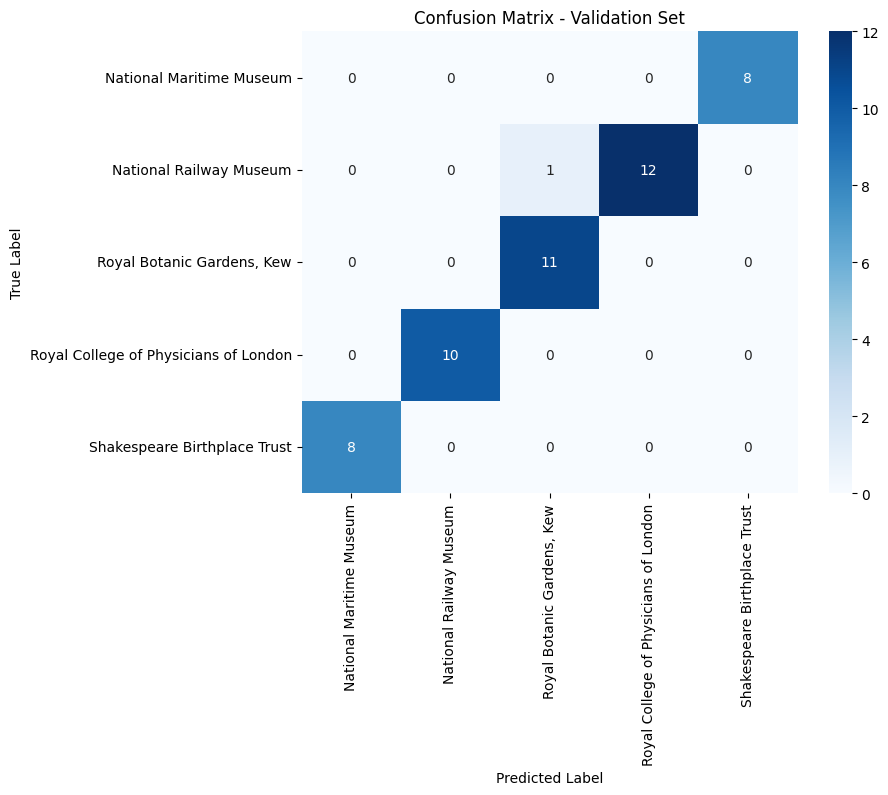

                                       precision    recall  f1-score   support

             National Maritime Museum       0.00      0.00      0.00         8
              National Railway Museum       0.00      0.00      0.00        13
           Royal Botanic Gardens, Kew       0.92      1.00      0.96        11
Royal College of Physicians of London       0.00      0.00      0.00        10
         Shakespeare Birthplace Trust       0.00      0.00      0.00         8

                             accuracy                           0.22        50
                            macro avg       0.18      0.20      0.19        50
                         weighted avg       0.20      0.22      0.21        50



In [22]:
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

label_mapping = {
    'National Maritime Museum': 0,
    'National Railway Museum': 1,
    'Royal Botanic Gardens, Kew': 2,
    'Royal College of Physicians of London': 3,
    'Shakespeare Birthplace Trust': 4
}

# Get predictions
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Generate confusion matrix
cm = confusion_matrix(valDF['label'], predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Print classification report
unique_labels = sorted(valDF['label'].unique())  # Get actual labels in dataset
correct_target_names = [name for name, idx in label_mapping.items() if idx in unique_labels]

print(classification_report(valDF['label'], predicted_labels, target_names=correct_target_names))


# Hyperparameter tuning

In [26]:
# Define base models
base_models = [
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract"
]

# Convert DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(trainDF[["content", "label"]])
val_dataset = Dataset.from_pandas(valDF[["content", "label"]])
test_dataset = Dataset.from_pandas(testDF[["content", "label"]])

# Function to fine-tune and evaluate models
def train_and_evaluate(base_model):
    print(f"\nTraining and evaluating {base_model}...\n")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=512)

    # Tokenize datasets
    train_data = train_dataset.map(tokenize_function, batched=True)
    val_data = val_dataset.map(tokenize_function, batched=True)
    test_data = test_dataset.map(tokenize_function, batched=True)

    # Remove unnecessary columns
    train_data = train_data.remove_columns(["content"])
    val_data = val_data.remove_columns(["content"])
    test_data = test_data.remove_columns(["content"])

    train_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_data.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    # Load model for classification
    model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=5)

    training_args = TrainingArguments(
    output_dir="bert_finetuned_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",  # Fix here
    greater_is_better=True  # Since higher F1 is better
    )


    # Data collator for dynamic padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Define evaluation function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        accuracy = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)

        per_class_scores = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)

        print("\nPer-Class Evaluation Metrics:")
        for i in range(len(per_class_scores[0])):
            print(f"Class {i}: Precision={per_class_scores[0][i]:.4f}, Recall={per_class_scores[1][i]:.4f}, F1={per_class_scores[2][i]:.4f}")

        return {
            "accuracy": accuracy,
            "macro_precision": precision,
            "macro_recall": recall,
            "macro_f1": f1
        }

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=val_data,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set
    print(f"\nEvaluating {base_model} on the validation set...\n")
    trainer.evaluate()

    # Save the best model
    trainer.save_model(f"{base_model}_best_model")

# Train and evaluate each model
for model_name in base_models:
    train_and_evaluate(model_name)



Training and evaluating bert-base-uncased...



Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-0bd81cb020d8>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,1.351500,2.033021,0.080000,0.200000,0.072727,0.106667
2,0.757900,2.231277,0.240000,0.226154,0.238636,0.228571
3,0.299800,2.904218,0.220000,0.157143,0.200000,0.176000
4,0.093700,3.577778,0.220000,0.169231,0.200000,0.183333
5,0.044800,4.081646,0.220000,0.169231,0.200000,0.183333
6,0.040900,4.340329,0.220000,0.157143,0.200000,0.176000
7,0.029400,4.484283,0.220000,0.157143,0.200000,0.176000
8,0.013200,4.523516,0.220000,0.169231,0.200000,0.183333



Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=1.0000, Recall=0.3636, F1=0.5333
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9000, Recall=0.8182, F1=0.8571
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.2308, Recall=0.3750, F1=0.2857

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.7857, Recall=1.0000, F1=0.8800
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1


Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9000, Recall=0.8182, F1=0.8571
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.2308, Recall=0.3750, F1=0.2857

Training and evaluating roberta-base...



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-0bd81cb020d8>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,1.470700,1.812116,0.000000,0.000000,0.000000,0.000000
2,0.947700,2.891508,0.060000,0.200000,0.054545,0.085714
3,0.432800,3.113227,0.240000,0.223333,0.225000,0.222074
4,0.123000,3.762389,0.240000,0.225000,0.225000,0.225000
5,0.095100,4.449422,0.180000,0.247222,0.177273,0.204085
6,0.037300,4.600488,0.260000,0.213675,0.250000,0.230392
7,0.024500,4.913597,0.240000,0.194231,0.225000,0.208333
8,0.007600,4.906165,0.260000,0.227778,0.250000,0.238363



Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=1.0000, Recall=0.2727, F1=0.4286
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9167, Recall=1.0000, F1=0.9565
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.2000, Recall=0.1250, F1=0.1538

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1


Per-Class Evaluation Metrics:
Class 0: Precision=0.2222, Recall=0.2500, F1=0.2353
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9167, Recall=1.0000, F1=0.9565
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Training and evaluating distilbert-base-uncased...



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-0bd81cb020d8>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,1.278500,1.807977,0.060000,0.250000,0.061364,0.094872
2,0.834600,2.175654,0.180000,0.200000,0.163636,0.180000
3,0.357600,2.558098,0.220000,0.169231,0.200000,0.183333
4,0.126500,3.071641,0.220000,0.157143,0.200000,0.176000
5,0.080100,3.577478,0.220000,0.183333,0.200000,0.191304
6,0.063000,3.805786,0.220000,0.183333,0.200000,0.191304
7,0.075300,3.915483,0.220000,0.183333,0.200000,0.191304
8,0.033800,3.944545,0.220000,0.183333,0.200000,0.191304



Per-Class Evaluation Metrics:
Class 0: Precision=0.2500, Recall=0.1250, F1=0.1667
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=1.0000, Recall=0.1818, F1=0.3077
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=1.0000, Recall=0.8182, F1=0.9000
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.8462, Recall=1.0000, F1=0.9167
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1


Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.9167, Recall=1.0000, F1=0.9565
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.0000, Recall=0.0000, F1=0.0000

Training and evaluating microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract...



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

Map:   0%|          | 0/155 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-0bd81cb020d8>:86: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,1.304300,1.804534,0.080000,0.188889,0.086364,0.109244
2,0.713900,2.436252,0.200000,0.285714,0.202273,0.235556
3,0.363200,2.681962,0.220000,0.208081,0.213636,0.210695
4,0.143500,3.277905,0.220000,0.255556,0.220455,0.235630
5,0.060800,3.950865,0.200000,0.183636,0.188636,0.185859
6,0.046600,4.402236,0.200000,0.222222,0.195455,0.207059
7,0.035900,4.699880,0.200000,0.202222,0.188636,0.194958
8,0.009300,4.759661,0.220000,0.224444,0.213636,0.218487


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Per-Class Evaluation Metrics:
Class 0: Precision=0.1667, Recall=0.1250, F1=0.1429
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.6667, Recall=0.1818, F1=0.2857
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.1111, Recall=0.1250, F1=0.1176

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=1.0000, Recall=0.6364, F1=0.7778
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.4286, Recall=0.3750, F1=0.4000

Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.8182, Recall=0.8182, F1=0.8182
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.2222, Recall=0.2500, F1=0.2353

Per-Class Evaluation Metrics:
Class 0: Precision=0.2222, Recall=0.2500, F1=0.2353
Class 1: Precision=0.0000, Recall=0.0000, F1


Per-Class Evaluation Metrics:
Class 0: Precision=0.2222, Recall=0.2500, F1=0.2353
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.8889, Recall=0.7273, F1=0.8000
Class 3: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 4: Precision=0.1667, Recall=0.1250, F1=0.1429


# Final evaluation and deployment

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def evaluate_model_on_test(test_dataset, model, tokenizer):
    predictions, labels = [], []

    # Iterate over the test dataset to predict and calculate metrics
    for example in test_dataset:
        inputs = tokenizer(example["content"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
        output = model(**inputs)
        predicted_class = output.logits.argmax(dim=-1).item()
        predictions.append(predicted_class)
        labels.append(example["label"])

    # Compute metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)

    # Per-class scores
    per_class_scores = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)

    print("\nPer-Class Evaluation Metrics:")
    for i, (p, r, f) in enumerate(zip(per_class_scores[0], per_class_scores[1], per_class_scores[2])):
        print(f"Class {i}: Precision={p:.4f}, Recall={r:.4f}, F1={f:.4f}")

    return {
        "accuracy": accuracy,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1
    }


# Load BERT model for classification (num_labels = 5)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

# Evaluate on the test set
metrics = evaluate_model_on_test(test_dataset, model, tokenizer)
print(metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Per-Class Evaluation Metrics:
Class 0: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 1: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 2: Precision=0.0000, Recall=0.0000, F1=0.0000
Class 3: Precision=0.1081, Recall=0.6667, F1=0.1860
Class 4: Precision=0.2500, Recall=0.2308, F1=0.2400
{'accuracy': 0.14, 'macro_precision': 0.07162162162162163, 'macro_recall': 0.17948717948717946, 'macro_f1': 0.0852093023255814}
